# Detection and tracking of deep convection using ABI
Detection combines elements of three existing methods:
1. Water vapour difference (WVD) based thresholdin (e.g. Muller, 2018  "The Role of NWP Filter for the Satellite Based Detectionof Cumulonimbus Clouds", Muller, 2019 "A Novel Approach for the Detection ofDeveloping Thunderstorm Cells"). As the WVD temperature is relative to the tropopause temperature it avoids aving to change the threshold to deal with different meteorologies.
2. Edge based region classification (Dim, 2013 "Alternative  Approach  for  Satellite  Cloud  Classification:  Edge Gradient Application). Edge based detection allows the entire cloud anvil to be detected without having to lower the threshold value.
3. "3D" region classification by watershedding over a stack of temporally spaced images (Fiolleau, 2013 "An Algorithm for the Detection and Tracking of Tropical Mesoscale Convective  Systems  Using  Infrared  Images  From  Geostationary  Satellite"). This method helps with the detection of deep convective clouds in early and late stages of thei lifecycles (when they don't meet the threshold in a single framw) and also in the handling of merged cloud objects, as all merged clouds are detected as a single 'object'.

All channels used are common to the ABI, AHI and SEVIRI sensors, so this detection method should be applicable to all without major changes


In [6]:
from __future__ import print_function, division
import tobac
import numpy as np
from numpy import ma
import xarray as xr
from glob import glob
from datetime import datetime, timedelta
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from pyproj import Proj
import xarray as xr
from skimage.feature import peak_local_max
from skimage.morphology import local_minima, h_minima, selem, star, ball, watershed
from scipy.ndimage import label, find_objects
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.morphology import grey_erosion, grey_dilation, grey_opening, grey_closing, binary_opening, binary_dilation
from scipy.signal import convolve
from scipy import interpolate
import SimpleITK

## Define functions

In [57]:
# ABI data handling functions
def get_abi_lat_lon(dataset):
    # Get the latitude and longitude of points in an ABI image field from an xarray dataset
    p = Proj(proj='geos', h=dataset.goes_imager_projection.perspective_point_height,
             lon_0=dataset.goes_imager_projection.longitude_of_projection_origin,
             sweep=dataset.goes_imager_projection.sweep_angle_axis)
    # The dataset x and y fields are the viewing angles of the imager
    xx, yy = np.meshgrid(dataset.x.data*dataset.goes_imager_projection.perspective_point_height,
                         dataset.y.data*dataset.goes_imager_projection.perspective_point_height)
    lons, lats = p(xx, yy, inverse=True)
    # Replace fill values with NaNs
    lons[lons>=1E30] = np.nan
    lats[lats>=1E30] = np.nan
    return lats, lons

def get_abi_pixel_area(dataset):
    # Find the area of each pixel (in square km) from the xarray dataset
    lat, lon = get_abi_lat_lon(dataset)
    nadir_res = float(dataset.spatial_resolution.split('km')[0])
    xx, yy = np.meshgrid(dataset.x.data*dataset.goes_imager_projection.perspective_point_height,
                         dataset.y.data*dataset.goes_imager_projection.perspective_point_height)
    lx_factor = np.cos(np.abs(np.radians(dataset.goes_imager_projection.longitude_of_projection_origin-lon))+np.abs(xx))
    ly_factor = np.cos(np.abs(np.radians(dataset.goes_imager_projection.latitude_of_projection_origin-lat))+np.abs(yy))
    area = nadir_res**2/(lx_factor*ly_factor)
    return area

def get_abi_IR(dataset):
    # Returns the IR brightness temperature of ABI IR fields (channels 7-16)
    planck_shape = dataset.planck_fk2.shape
    planck_ndims = len(planck_shape)
    data_shape = dataset.Rad.shape
    data_ndims = len(data_shape)
    planck_reshape = planck_shape + (1,)*(data_ndims-planck_ndims)
    bt = (dataset.planck_fk2.data.reshape(planck_reshape) / (np.log((dataset.planck_fk1.data.reshape(planck_reshape) / dataset.Rad.data) + 1)) - dataset.planck_bc1.data.reshape(planck_reshape)) / dataset.planck_bc2.data.reshape(planck_reshape)
    DQF = dataset.DQF.data
    bt[DQF<0] = np.nan
    bt[DQF>1] = np.nan
    return bt

def get_abi_ref(dataset):
    # Returns the reflectance of ABI SW fields (channels 1-6)
    ref = dataset.Rad.data * dataset.kappa0.data
    DQF = dataset.DQF.data
    ref[DQF<0] = np.nan
    ref[DQF>1] = np.nan
    return ref

def get_abi_IR_ds(dataset, check=False):
    bt = (dataset.planck_fk2 / (np.log((dataset.planck_fk1 / dataset.Rad) + 1)) - dataset.planck_bc1) / dataset.planck_bc2
    if check:
        DQF = dataset.DQF
        bt[DQF<0] = np.nan
        bt[DQF>1] = np.nan
    return bt

def get_abi_ref_ds(dataset, check=False):
    ref = dataset.Rad * dataset.kappa0
    if check:
        DQF = dataset.DQF
        ref[DQF<0] = np.nan
        ref[DQF>1] = np.nan
    return ref


def get_wvd_from_files(C8_file, C10_file):
    # Get the difference between the BT of two different channels from ABI lvl1 files
    with xr.open_dataset(C8_file) as C8_ds:
        C8_BT = get_abi_IR(C8_ds)
    with xr.open_dataset(C10_file) as C10_ds:
        C10_BT = get_abi_IR(C10_ds)
    wvd = C8_BT - C10_BT
    return wvd

def get_goes_abi_files(input_file):
    # Returns a list of the datetime and all 16 channel file names for ABI lvl1 data from the path of the name of one file
    datestr = input_file.split('/')[-1].split('_')[3]
    yearstr = datestr[1:5]
    doystr = datestr[5:8]
    hourstr = datestr[8:10]
    minstr = datestr[10:12]
    secstr = datestr[12:14]
    file_date = datetime(year=int(yearstr), month=1, day=1, hour=int(hourstr), minute=int(minstr), second=int(secstr)) + timedelta(days=int(doystr)-1)
    files = glob('/'.join(input_file.split('/')[:-1])+'/'+input_file.split('/')[-1].split('_')[0][:-2]+'*s'+yearstr+doystr+hourstr+minstr+'*.nc')
    return [file_date]+files

def contrast_correction(color, contrast):
    """
    Modify the contrast of an R, G, or B color channel
    See: #www.dfstudios.co.uk/articles/programming/image-programming-algorithms/image-processing-algorithms-part-5-contrast-adjustment/

    Input:
        C - contrast level
    """
    F = (259*(contrast + 255))/(255.*259-contrast)
    COLOR = F*(color-.5)+.5
    COLOR = np.minimum(COLOR, 1)
    COLOR = np.maximum(COLOR, 0)
    return COLOR

# Shrinks an array by factor l in each dimension, returning the mean value for each lxl region of the array
def get_ds_area_mean(ds, l=1, axis=None):
    if axis is None:
        interp_dims = {dim:ds[dim].data[:ds[dim].size//l*l].reshape(-1,l).mean(-1) for dim in ds.dims}
    else:
        if not hasattr(axis, '__iter__'):
            axis = [axis]
        interp_dims = {ds.dims[i]:ds[ds.dims[i]].data[:ds[ds.dims[i]].size//l*l].reshape(-1,l).mean(-1) for i in axis}
    return ds.interp(interp_dims)

def get_abi_rgb(C01_ds, C02_ds, C03_ds, IR_ds=None, gamma=0.4, contrast=75, l=1):
    # Produce false-colour RGB images using ABI
    if IR_ds != None:
        l = l*2
    R = get_ds_area_mean(get_abi_ref_ds(C02_ds), l*2)
    G = get_ds_area_mean(get_abi_ref_ds(C03_ds), l)
    B = get_ds_area_mean(get_abi_ref_ds(C01_ds), l)
    R = np.maximum(R, 0)
    R = np.minimum(R, 1)
    G = np.maximum(G, 0)
    G = np.minimum(G, 1)
    B = np.maximum(B, 0)
    B = np.minimum(B, 1)
    R = np.power(R, gamma)
    G = np.power(G, gamma)
    B = np.power(B, gamma)
    G_true = 0.48358168 * R.data + 0.45706946 * B.data + 0.06038137 * G.data
    G_true = np.maximum(G_true, 0)
    G_true = np.minimum(G_true, 1)
    if IR_ds != None:
        IR = get_ds_area_mean(get_abi_IR(IR_ds), l//2)
        IR = np.maximum(IR, 90)
        IR = np.minimum(IR, 313)
        IR = (IR-90)/(313-90)
        IR = (1 - IR.data)/1.5
        RGB = contrast_correction(np.dstack([np.maximum(R.data, IR), np.maximum(G_true, IR), np.maximum(B.data, IR)]), contrast=contrast)
    else:
        RGB = contrast_correction(np.dstack([R, G_true, B]), contrast=contrast)
    
    return RGB

# New Sobel functions (pre-existing functions are either 2d only, harder to use or slow)
def get_sobel_matrix(ndims):
    sobel_matrix = np.array([-1,0,1])
    for i in range(ndims-1):
        sobel_matrix = np.multiply.outer(np.array([1,2,1]), sobel_matrix)
    return sobel_matrix

# Faster 'convolution' function to find the gradient for the sobel case
def convolve_grad(input_matrix, sobel_matrix):
    output_matrix = np.zeros(input_matrix.shape)
    for i in range(np.product(sobel_matrix.shape)):
        if sobel_matrix.ravel()[i] != 0:
            output_matrix[[slice([0,1][ind<1], [None,-1][ind>1]) for ind in np.unravel_index(i, sobel_matrix.shape)]] += (input_matrix[[slice([0,1][ind>1], [None,-1][ind<1]) for ind in np.unravel_index(i, sobel_matrix.shape)]] - input_matrix[[slice([0,1][ind<1], [None,-1][ind>1]) for ind in np.unravel_index(i, sobel_matrix.shape)]]) * sobel_matrix.ravel()[i]
    return output_matrix

# Faster 'convolution' function to find the gradient for the sobel case -- uphill only version
def convolve_grad_uphill(input_matrix, sobel_matrix, downhill=False):
    output_matrix = np.zeros(input_matrix.shape)
    for i in range(np.product(sobel_matrix.shape)):
        if sobel_matrix.ravel()[i] != 0:
            if downhill:
                output_matrix[[slice([0,1][ind<1],[None,-1][ind>1]) for ind in np.unravel_index(i,sobel_matrix.shape)]] += np.minimum(input_matrix[[slice([0,1][ind>1],[None,-1][ind<1]) for ind in np.unravel_index(i,sobel_matrix.shape)]] - input_matrix[[slice([0,1][ind<1],[None,-1][ind>1]) for ind in np.unravel_index(i,sobel_matrix.shape)]],0) * sobel_matrix.ravel()[i]
            else:
                output_matrix[[slice([0,1][ind<1],[None,-1][ind>1]) for ind in np.unravel_index(i,sobel_matrix.shape)]] += np.maximum(input_matrix[[slice([0,1][ind>1],[None,-1][ind<1]) for ind in np.unravel_index(i,sobel_matrix.shape)]] - input_matrix[[slice([0,1][ind<1],[None,-1][ind>1]) for ind in np.unravel_index(i,sobel_matrix.shape)]],0) * sobel_matrix.ravel()[i]
    return output_matrix

# nD Sobel gradient function
def sobel(input_matrix, use_convolve=False):
    ndims = len(input_matrix.shape)
    sobel_matrix = get_sobel_matrix(ndims)
    output_matrix = np.zeros(input_matrix.shape)
    if use_convolve:
        for i in range(ndims):
            if np.sum(np.isfinite(input_matrix)) == input_matrix.size:
                output_matrix += convolve(input_matrix, np.rollaxis(sobel_matrix,i))[[slice(1,-1)]*ndims]**2
            else:
                output_matrix += convolve(input_matrix, np.rollaxis(sobel_matrix,i), method='direct')[[slice(1,-1)]*ndims]**2
    else:
        for i in range(ndims):
            output_matrix += convolve_grad(input_matrix, np.rollaxis(sobel_matrix,i))**2
    output_matrix = output_matrix**0.5
    return output_matrix
    
# 'Uphill only' sobel operation. Finds only uphill slopes, to avoid masking smaller cloud objects
def uphill_sobel(input_matrix, downhill=False, uphill_positive=False, use_convolve=False):
    ndims = len(input_matrix.shape)
    sobel_matrix = get_sobel_matrix(ndims)
    if uphill_positive:
        sobel_matrix = np.abs(sobel_matrix)
    one_arr = np.zeros(sobel_matrix.size)
    one_arr[0] = 1
    output_matrix = np.stack([np.zeros(input_matrix.shape)]*ndims)
    if use_convolve:
        if downhill:
            for i in range(sobel_matrix.size):
                if np.sum(np.isfinite(input_matrix)) == input_matrix.size:
                    temp_matrix = np.minimum(convolve(input_matrix,np.roll(one_arr,i).reshape(sobel_matrix.shape))[[slice(1,-1)]*ndims]-input_matrix, 0)
                else:
                    temp_matrix = np.minimum(convolve(input_matrix,np.roll(one_arr,i).reshape(sobel_matrix.shape), method='direct')[[slice(1,-1)]*ndims]-input_matrix, 0)
                for j in range(ndims):
                    output_matrix[j] += temp_matrix * np.rollaxis(sobel_matrix,j).ravel()[i]
        else:
            for i in range(sobel_matrix.size):
                if np.sum(np.isfinite(input_matrix)) == input_matrix.size:
                    temp_matrix = np.maximum(convolve(input_matrix,np.roll(one_arr,i).reshape(sobel_matrix.shape))[[slice(1,-1)]*ndims]-input_matrix, 0)
                else:
                    temp_matrix = np.maximum(convolve(input_matrix,np.roll(one_arr,i).reshape(sobel_matrix.shape), method='direct')[[slice(1,-1)]*ndims]-input_matrix, 0)
                for j in range(ndims):
                    output_matrix[j] += temp_matrix * np.rollaxis(sobel_matrix,j).ravel()[i]
    else:
        for i in range(ndims):
            output_matrix[i] = convolve_grad_uphill(input_matrix, np.rollaxis(sobel_matrix,i), downhill=downhill)
    output_matrix = np.sum(output_matrix**2,0)**0.5
    return output_matrix

# Segmentation functions

def subsegment(bt, h_level=2.5):
    bt.fill_value = bt.max()
    peaks = np.all((h_minima(gaussian_filter(bt.filled(),0.5),h_level),local_minima(gaussian_filter(bt.filled(),0.5),ball(2)),bt.filled()<240), axis=0)
    segments = watershed(bt.filled(),label(peaks)[0], mask=np.logical_not(bt.mask))
    return segments

def plot_segments(obj, h_level=2.5):
    segments = subsegment(obj['BT'], h_level)
    print(np.max(segments))
    bt = obj['BT']
    colors = ['red','blue','green','orange','purple','yellow','cyan','magenta']
    colors += ['C'+str(i%10) for i in range(np.max(segments))]
    for i in range(segments.shape[0]):
        plt.figure()
        plt.imshow(bt[i],vmax=bt.fill_value,vmin=bt.min())
        for j in range(np.max(segments)):
            plt.contour(segments[i]==j+1,[0.5],colors=colors[j])
    return

def plot_segments_translated(obj, h_level=2.5):
    bt_trans = translate_BT(obj)
    segments = subsegment(bt_trans, h_level)
    print(np.max(segments))
    colors = ['red','blue','green','orange','purple','yellow','cyan','magenta']
    colors += ['C'+str(i%10) for i in range(np.max(segments))]
    for i in range(segments.shape[0]):
        plt.figure()
        plt.imshow(bt_trans[i],vmax=bt_trans.fill_value,vmin=bt_trans.min())
        for j in range(np.max(segments)):
            plt.contour(segments[i]==j+1,[0.5],colors=colors[j])
    return

## Load data from ABI lvl1 files
I've been using June 19th 2018 18:00-24:00 as a test case, it has an interesting mix of convective behaviour

In [10]:
# Find files (on Jasmin)
# 
goes_path = '/gws/nopw/j04/eo_shared_data_vol2/scratch/satellite/GOES16/RadC/2018/170/'
C08_files = glob(goes_path+'*/*C08_*.nc')
abi_files = get_goes_abi_files(C08_files[216])


/home/users/wkjones/miniconda2/envs/NEW/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less
/home/users/wkjones/miniconda2/envs/NEW/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater


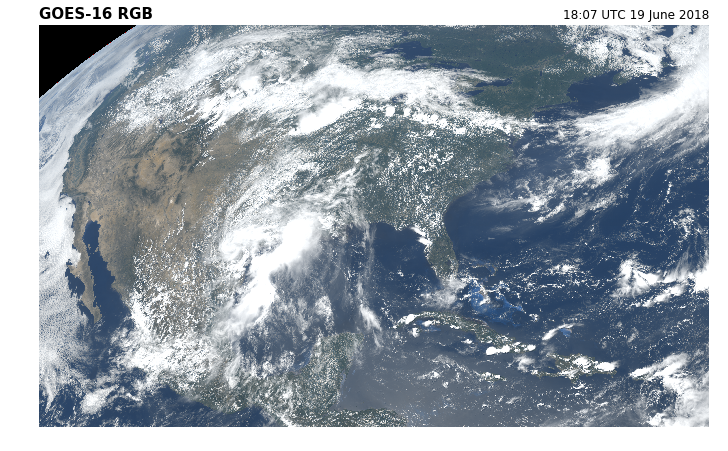

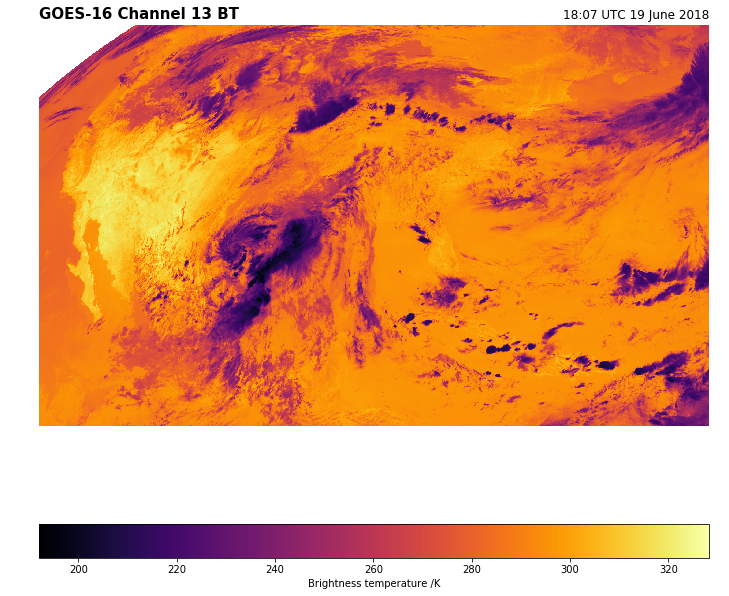

In [20]:
# Plot pseudo-RGB and IR:
with xr.open_dataset(abi_files[1]) as C01_ds, xr.open_dataset(abi_files[2]) as C02_ds, xr.open_dataset(abi_files[3]) as C03_ds:
    RGB = get_abi_rgb(C01_ds,C02_ds,C03_ds)
plt.figure(figsize=(12.0,8.0))
plt.imshow(RGB)
plt.axis('off')
plt.title('GOES-16 RGB', fontweight='semibold', loc='left', fontsize=15)
plt.title('%s' % abi_files[0].strftime('%H:%M UTC %d %B %Y'), loc='right')
# Plot IR (10.8 micron)
with xr.open_dataset(abi_files[13]) as ds:
    IR = get_abi_IR(ds)
plt.figure(figsize=(12.0,12.0))
plt.imshow(IR, cmap='inferno')
plt.axis('off')
plt.title('GOES-16 Channel 13 BT', fontweight='semibold', loc='left', fontsize=15)
plt.title('%s' % abi_files[0].strftime('%H:%M UTC %d %B %Y'), loc='right')
cb = plt.colorbar(orientation='horizontal')
cb.set_label('Brightness temperature /K')


/home/users/wkjones/miniconda2/envs/NEW/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less
/home/users/wkjones/miniconda2/envs/NEW/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater


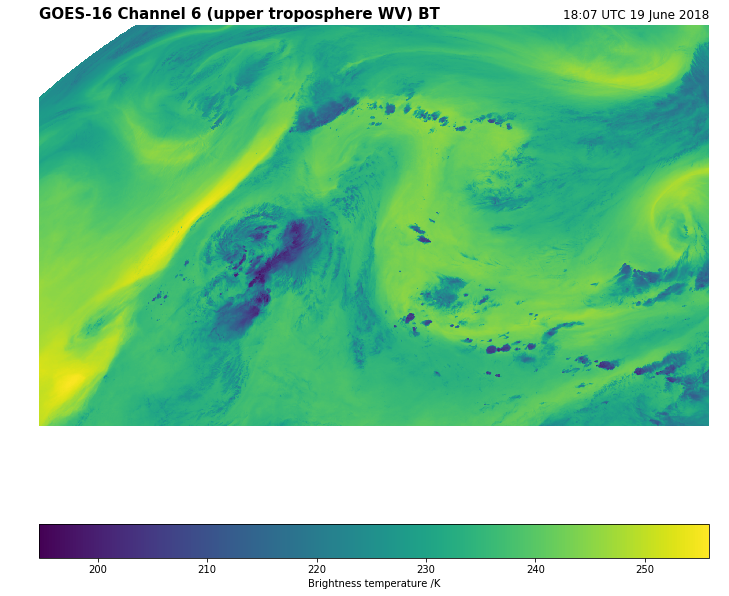

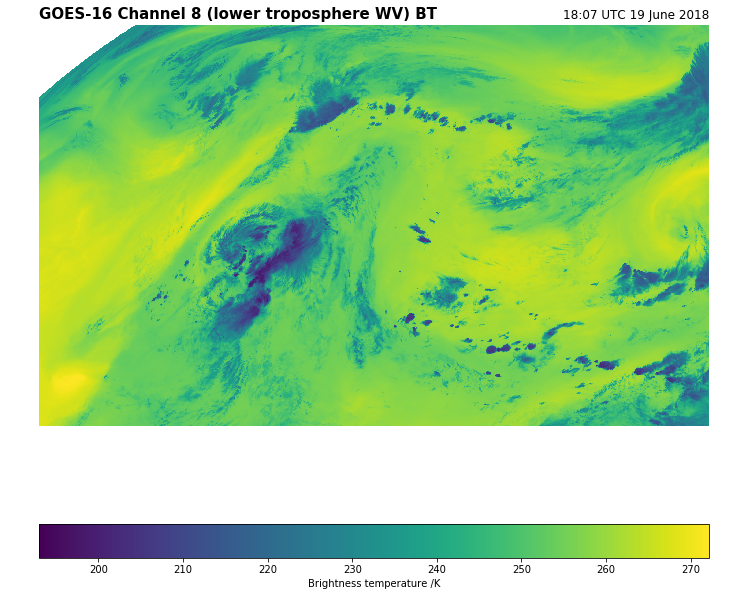

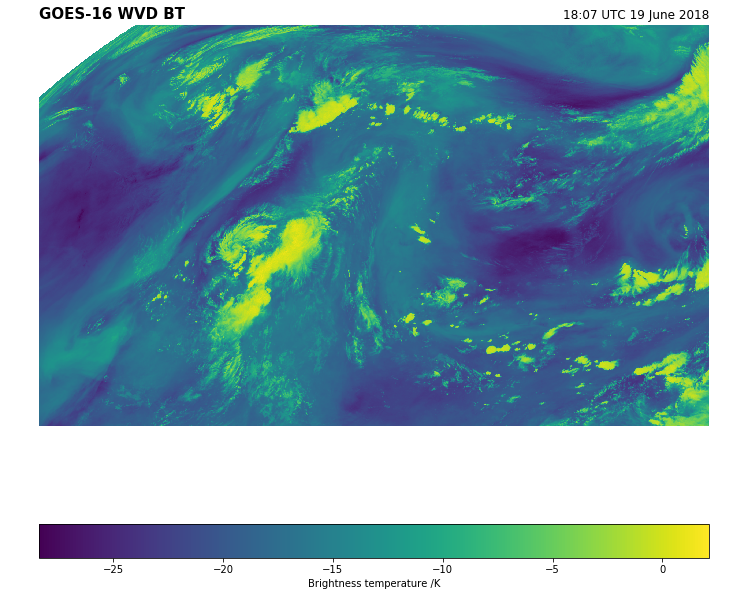

In [26]:
# Plot upper and lower troposphere water vapour channels (8 and 10) and the water vapour difference
with xr.open_dataset(abi_files[8]) as ds:
    ut_wv = get_abi_IR(ds)
plt.figure(figsize=(12.0,12.0))
plt.imshow(ut_wv)
plt.axis('off')
plt.title('GOES-16 Channel 6 (upper troposphere WV) BT', fontweight='semibold', loc='left', fontsize=15)
plt.title('%s' % abi_files[0].strftime('%H:%M UTC %d %B %Y'), loc='right')
cb = plt.colorbar(orientation='horizontal')
cb.set_label('Brightness temperature /K')

with xr.open_dataset(abi_files[10]) as ds:
    lt_wv = get_abi_IR(ds)
plt.figure(figsize=(12.0,12.0))
plt.imshow(lt_wv)
plt.axis('off')
plt.title('GOES-16 Channel 8 (lower troposphere WV) BT', fontweight='semibold', loc='left', fontsize=15)
plt.title('%s' % abi_files[0].strftime('%H:%M UTC %d %B %Y'), loc='right')
cb = plt.colorbar(orientation='horizontal')
cb.set_label('Brightness temperature /K')

plt.figure(figsize=(12.0,12.0))
plt.imshow(ut_wv-lt_wv)
plt.axis('off')
plt.title('GOES-16 WVD BT', fontweight='semibold', loc='left', fontsize=15)
plt.title('%s' % abi_files[0].strftime('%H:%M UTC %d %B %Y'), loc='right')
cb = plt.colorbar(orientation='horizontal')
cb.set_label('Brightness temperature /K')


Water vapour difference: Cloud tops closer to the tropopause are warmer due to the contribution from stratospheric water vapour in the 6.2 micron channel and blocking of the tropospheric water vapour

# Thresholding
Dim (2013) found that a value of -5K was best for detecting DCCs using the WVD field, and I've come to the same conclusion. Values below -15K are set as "definitely not deep convection", but this leaves a range of values in between where some are deep convective clouds, and some aren't

/home/users/wkjones/miniconda2/envs/NEW/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/home/users/wkjones/miniconda2/envs/NEW/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


Text(1,1,'18:07 UTC 19 June 2018')

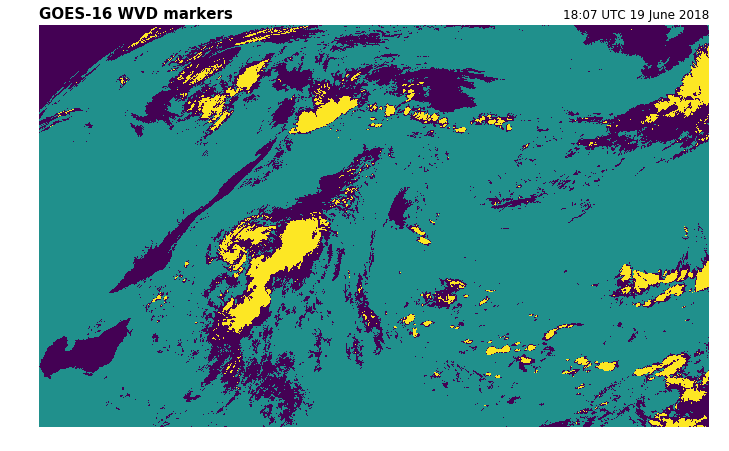

In [35]:
wvd = ut_wv-lt_wv
# Set upper and lower threshold values
upper_thresh = -5
lower_thresh = -15
markers = np.maximum(2*(wvd>upper_thresh),wvd<lower_thresh)
plt.figure(figsize=(12.0,12.0))
plt.imshow(markers)
plt.axis('off')
plt.title('GOES-16 WVD markers', fontweight='semibold', loc='left', fontsize=15)
plt.title('%s' % abi_files[0].strftime('%H:%M UTC %d %B %Y'), loc='right')


Legend: Yellow = above threshold, Teal = background, Dark blue = uncertain

# Edge detection and Watershedding
To fully detect the extent of detected DCCs an edge based approach is used. This allows a more conservative threshold to be used to avoid false detections without missing actual features.

A sobel based algorithm is used, which detects the gradient of the wvd field. I've been experimenting with a version that only takes 'uphill' gradients into account, to avoid masking small features. This edge field can then be watershedded using the previous markers

To improve the detection of edges, the split window difference (swd) is subtracted from the WVD field to remove thin, high clouds.

/home/users/wkjones/miniconda2/envs/NEW/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less
/home/users/wkjones/miniconda2/envs/NEW/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/home/users/wkjones/miniconda2/envs/NEW/lib/python2.7/site-packages/ipykernel_launcher.py:163: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Text(1,1,'18:07 UTC 19 June 2018')

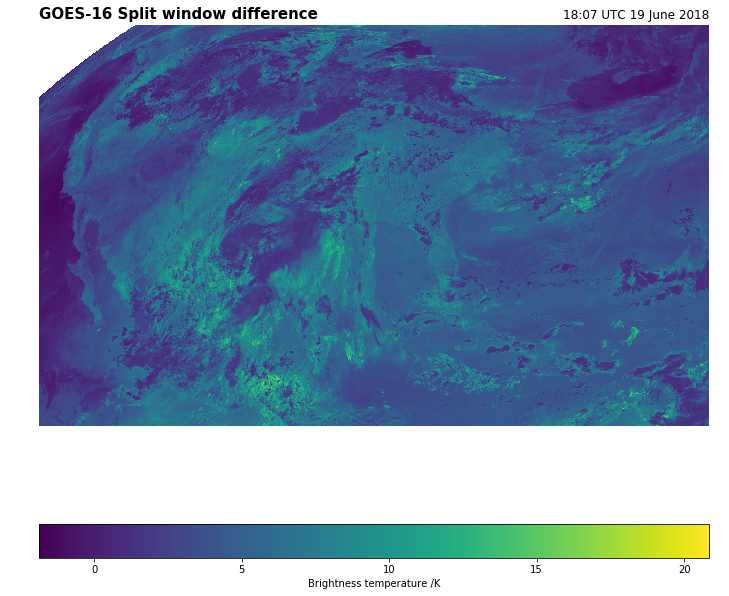

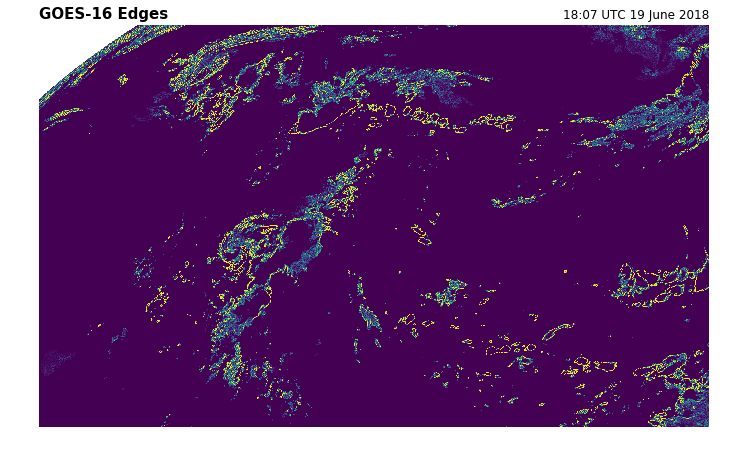

In [55]:
swd = get_wvd_from_files(abi_files[13], abi_files[15])
plt.figure(figsize=(12.0,12.0))
plt.imshow(swd)
plt.axis('off')
plt.title('GOES-16 Split window difference', fontweight='semibold', loc='left', fontsize=15)
plt.title('%s' % abi_files[0].strftime('%H:%M UTC %d %B %Y'), loc='right')
cb = plt.colorbar(orientation='horizontal')
cb.set_label('Brightness temperature /K')

# Limit the wvd field to between the upper and lower thresholds
wvd_thresh = np.maximum(np.minimum(wvd-swd,upper_thresh),lower_thresh)
edges = uphill_sobel(wvd_thresh)
plt.figure(figsize=(12.0,12.0))
plt.imshow(edges, vmin=0, vmax=10)
plt.axis('off')
plt.title('GOES-16 Edges', fontweight='semibold', loc='left', fontsize=15)
plt.title('%s' % abi_files[0].strftime('%H:%M UTC %d %B %Y'), loc='right')


/home/users/wkjones/miniconda2/envs/NEW/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
/home/users/wkjones/miniconda2/envs/NEW/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/users/wkjones/miniconda2/envs/NEW/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


Text(1,1,'18:07 UTC 19 June 2018')

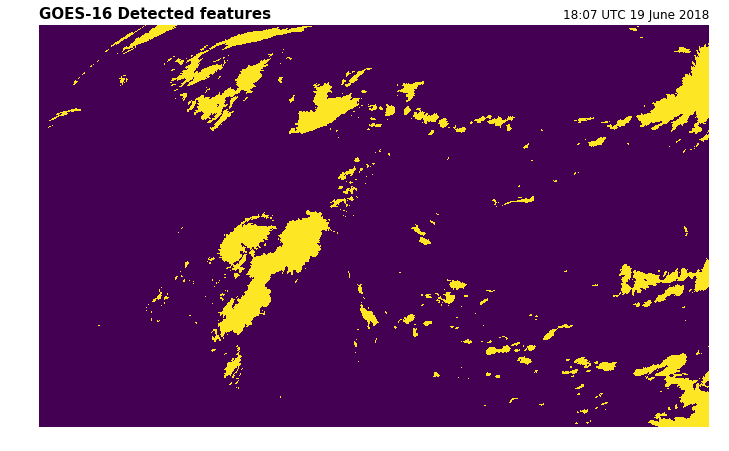

In [52]:
# Now watershed over this field using the previous markers
# Slightly modified markers to avoid them overlapping where edges are present and throwing off the watershedding
markers = np.zeros(edges.shape)
markers = np.maximum(markers, 1*np.logical_and(wvd<lower_thresh,edges==0))
edges_std = np.nanstd(edges)
markers = np.maximum(markers, 2*np.logical_and(wvd>upper_thresh,edges<edges_std))
filled = watershed(edges, markers)
plt.figure(figsize=(12.0,12.0))
plt.imshow(filled>1)
plt.axis('off')
plt.title('GOES-16 Detected features', fontweight='semibold', loc='left', fontsize=15)
plt.title('%s' % abi_files[0].strftime('%H:%M UTC %d %B %Y'), loc='right')


Text(1,1,'18:07 UTC 19 June 2018')

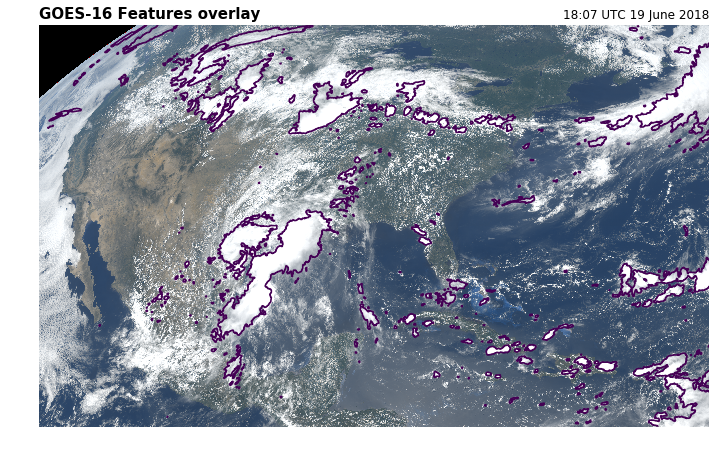

In [53]:
plt.figure(figsize=(12.0,8.0))
plt.imshow(RGB)
plt.contour(np.repeat(np.repeat(filled,2,axis=0),2,axis=1),[1.5])
plt.axis('off')
plt.title('GOES-16 Features overlay', fontweight='semibold', loc='left', fontsize=15)
plt.title('%s' % abi_files[0].strftime('%H:%M UTC %d %B %Y'), loc='right')


# 3D improvements
Instead of performing this spearately on each frame - as shown here - better results can be obtained by stacking multiple time steps and performing this method on the resulting "3D" array (as in Fiolleau, 2013). This helps prevent intermittent detections and flickering. Furthermore, regions only need to pass the threshold once during their lifetime to be detected as long as they overlap between images, allowing a higher threshold to be used, and earlier convection to be detected

# Tracking
Lets convert these features into tobac format and use the tobac tracking module to produce some tracks

Frame 286: 83 trajectories present.


Text(1,1,'19 June 2018')

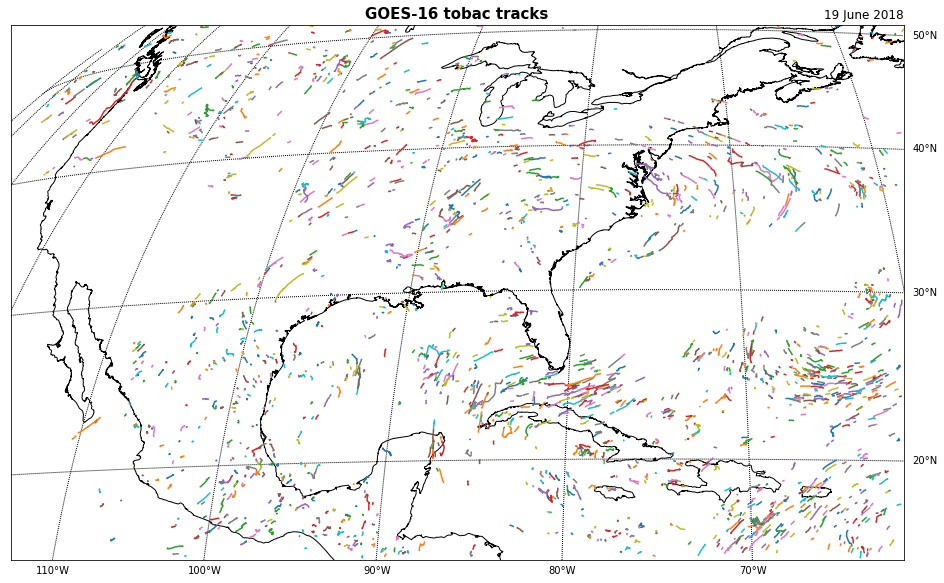

In [59]:
import tobac

def get_central_xy(obj):
    xx,yy = np.meshgrid(np.arange(obj['slice'][1].start,obj['slice'][1].stop),np.arange(obj['slice'][0].start,obj['slice'][0].stop))
    central_x = ma.array(np.stack([xx]*obj['feature_mask'].shape[0]),mask=np.logical_not(obj['feature_mask'])).mean(axis=(1,2)).data
    central_y = ma.array(np.stack([yy]*obj['feature_mask'].shape[0]),mask=np.logical_not(obj['feature_mask'])).mean(axis=(1,2)).data
    return central_x, central_y

frame = []
hdim_1 = []
hdim_2 = []
idx = []
num = []
threshold_value = []
feature = []
time = []
timestr = []
latitude = []
longitude = []

for i, obj in enumerate(objects):
    central_x, central_y = get_central_xy(obj)
    hdim_1.extend(central_y)
    hdim_2.extend(central_x)
    idx.extend([i+1]*len(central_x))
    num.extend(obj['pixel_count'])
    threshold_value.extend(obj['peak_BT'].data)
    datetimes = [f[0] for f in obj['files']]
    time.extend(datetimes)
    timestr.extend([str(dt) for dt in datetimes])
    latitude.extend([ll[0] for ll in obj['central_latlon']])
    longitude.extend([ll[1] for ll in obj['central_latlon']])
    
time = np.array(time)
wh_time = np.logical_and(time>=datetime(2018,6,19,6),time<datetime(2018,6,20,6))
time = time[wh_time]
hdim_1 = np.array(hdim_1)[wh_time]
hdim_2 = np.array(hdim_2)[wh_time]
idx = np.array(idx)[wh_time]
num = np.array(num)[wh_time]
threshold_value = np.array(threshold_value)[wh_time]
timestr = np.array(timestr)[wh_time]
latitude = np.array(latitude)[wh_time]
longitude = np.array(longitude)[wh_time]
feature = np.arange(1,time.size+1)
uniq_dates = list(np.unique(time))
date_range = pd.date_range(min(uniq_dates),max(uniq_dates),(max(uniq_dates)-min(uniq_dates)).total_seconds()//300+1).tolist()
frame = np.array([date_range.index(t) for t in time])

feature_df = pd.DataFrame(dict(frame=frame,hdim_1=hdim_1,hdim_2=hdim_2,idx=idx,num=num,threshold_value=threshold_value,feature=feature,time=time,timestr=timestr,latitude=latitude,longitude=longitude))

dt,dxy = 300,2000
parameters_linking={}
parameters_linking['v_max']=30
parameters_linking['stubs']=2
parameters_linking['order']=1
parameters_linking['extrapolate']=2
parameters_linking['memory']=3 #Added 1 step of memory to deal with the missing frames, perhaps more needed?
parameters_linking['adaptive_stop']=0.2
parameters_linking['adaptive_step']=0.95
parameters_linking['subnetwork_size']=100
parameters_linking['method_linking']= 'predict'

Track=tobac.linking_trackpy(feature_df,np.zeros((1500,2500)),dt=dt,dxy=dxy,**parameters_linking)

def get_abi_basemap(ds):
    lon_0 = ds.goes_imager_projection.longitude_of_projection_origin
    h = ds.goes_imager_projection.perspective_point_height
    X = ds.x*h
    Y = ds.y*h
    basemap = Basemap(projection='geos', lon_0=lon_0, area_thresh=5000, resolution='i',
                      llcrnrx=np.nanmin(X), llcrnry=np.nanmin(Y),
                      urcrnrx=np.nanmax(X), urcrnry=np.nanmax(Y))
    return basemap

axis_extent=[-145, -50, 10, 55]

plt.figure(figsize=(16.0,12.0))
with xr.open_dataset(objects[0]['files'][0][13]) as ds:
    m = get_abi_basemap(ds)
m.drawcoastlines()
m.drawparallels(np.arange(20.,51,10.),labels=[False,True,False,False])
m.drawmeridians(np.arange(180.,351,10.),labels=[False,False,False,True])
for cell in Track['cell'].dropna().unique():
    track_i=Track[Track['cell']==cell]    
    x,y = m(track_i['longitude'].tolist(),track_i['latitude'].tolist())
    m.plot(x,y)
plt.title('GOES-16 tobac tracks', fontweight='semibold', fontsize=15)
plt.title('%s' % objects[0]['files'][0][0].strftime('%d %B %Y'), loc='right')

# Subsegmentation
The features detected previously can be fed into the tobac tracking module as is (see plots in presentation), but these features aren't actually individual cores, but instead regions of deep convective clouds. This causes problems, as the centre of these regions can jump around as individual cores develop or dissipate, resulting in broken tracks. I have been working on a subsegmentation process to break these regions into individual deep convective clouds, allowing them to be tracked properly. Fabian's geometric segmentation would be good here as well

In [56]:
# Load pre-processed objects from file
objects_path='/gws/nopw/j04/eo_shared_data_vol2/scratch/satellite/GOES16/objects/'
object_files = []
for i in range(170,171):
    object_files.extend(glob(objects_path+'RadC_BTobjects_'+str(i).zfill(3)+'.npz'))
    object_files.extend(glob(objects_path+'RadC_BTobjects_'+str(i).zfill(3)+'hd.npz'))
with np.load(object_files[0]) as o:
    objects = o['objects'].tolist()
with np.load(object_files[1]) as o:
    objects += o['objects'].tolist()

3


/home/users/wkjones/miniconda2/envs/NEW/lib/python2.7/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/users/wkjones/miniconda2/envs/NEW/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


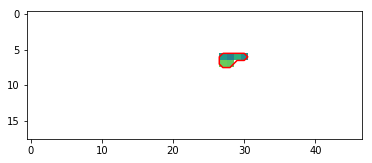

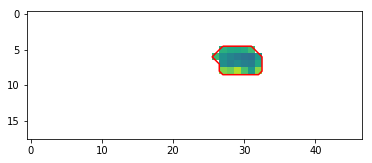

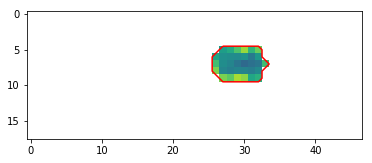

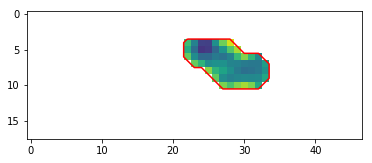

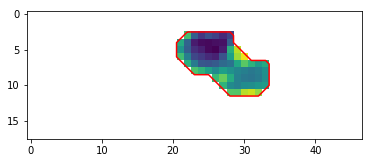

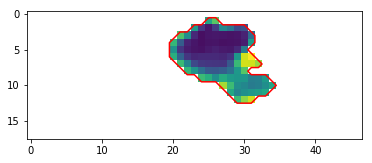

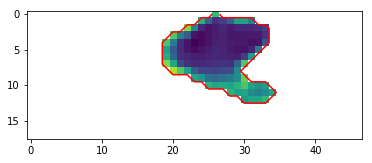

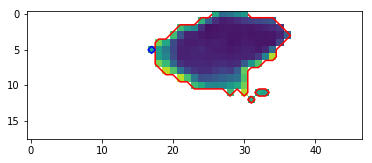

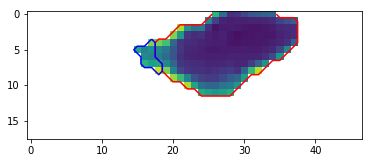

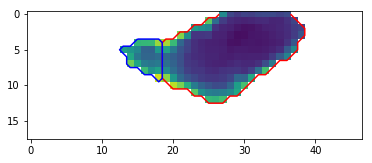

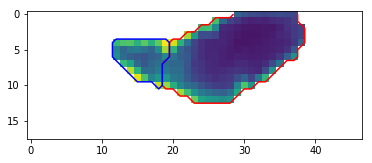

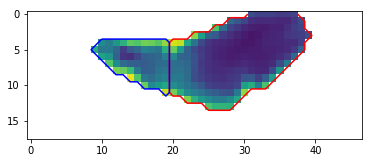

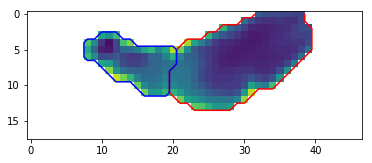

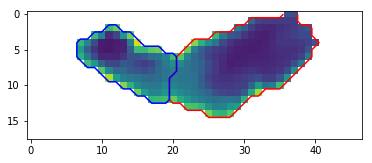

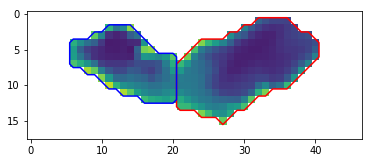

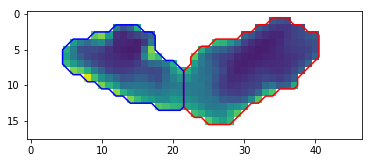

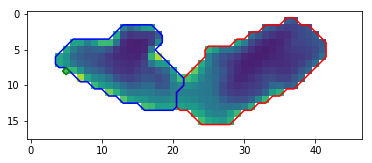

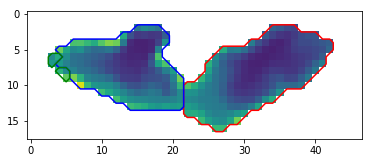

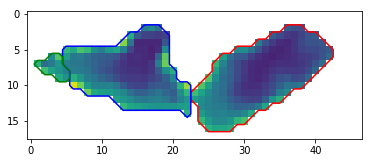

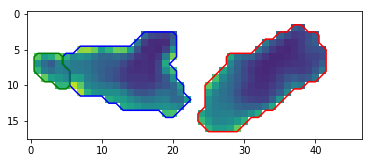

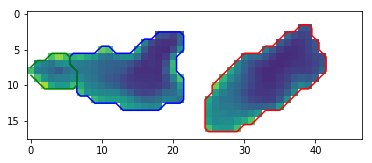

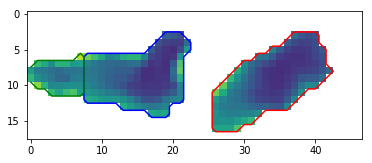

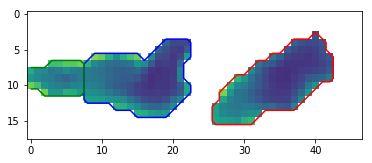

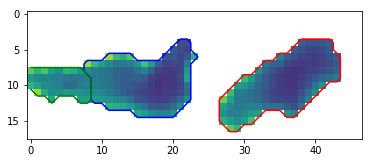

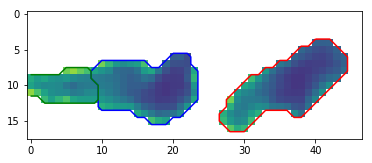

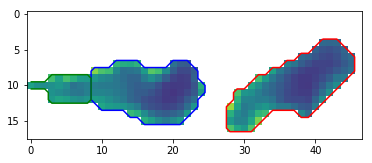

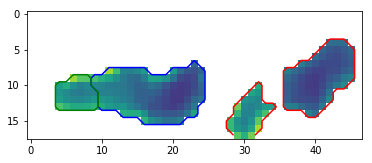

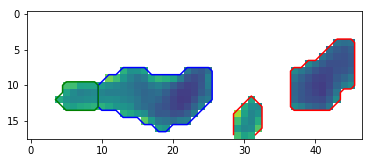

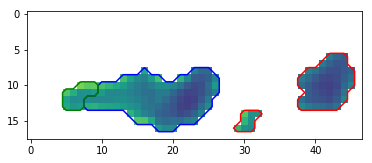

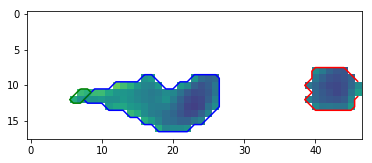

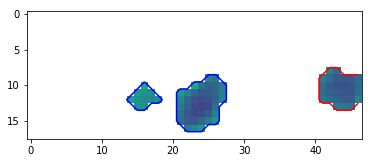

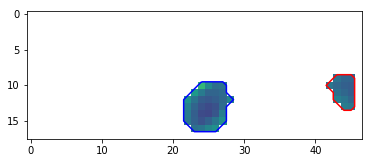

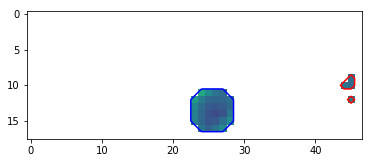

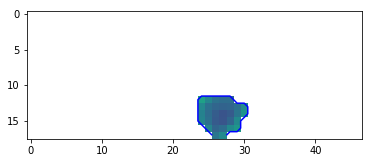

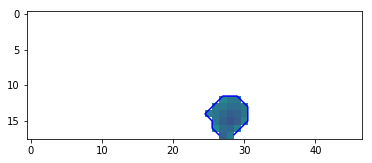

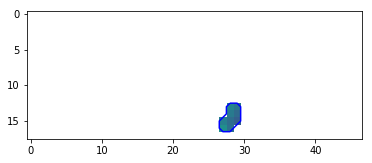

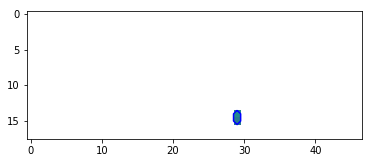

In [58]:
plot_segments(objects[4],2)